In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19

# Creating training, validation, and testing datasets

For this part, we are getting our dataset from the DIV2K dataset. We will be using the HR images from the dataset and downscaling them to create the LR images. We will be using bicubic interpolation to downscale the images. We will be using the HR images as our target images and the LR images as our input images.

In [3]:
# Compare the images
def compare_images(imageA, imageB):
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True, channel_axis=2, data_range=255)
    p = psnr(imageA, imageB, data_range=255)
    return m, s, p

In [4]:
# Prepare data
np.random.seed(42)

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            images.append(img)
    return images


hr_images = load_images('Dataset/Cropped/')
lr_images = load_images('Dataset/Processed/')

combined_data = list(zip(lr_images, hr_images))
train_data, test_data = train_test_split(combined_data, test_size=0.3)
val_data, test_data = train_test_split(test_data, test_size=0.5)

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)


In [5]:
# Normalize the pixel values to [0, 1]
def normalize(data):
    return np.array([np.array(img, dtype=np.float32) / 255.0 for img in data])

X_train, y_train = normalize(X_train), normalize(y_train)
X_test, y_test = normalize(X_test), normalize(y_test)
X_val, y_val = normalize(X_val), normalize(y_val)

# Define the loss functions

We will be using the following loss functions for training the SRCNN model:
- Mean Squared Error (MSE)
- Structural Similarity Index (SSIM)
- VGG-based perceptual loss

The following metrics will be used for evaluating the model:
- Mean Squared Error (MSE)
- Structural Similarity Index (SSIM)
- Peak Signal-to-Noise Ratio (PSNR)

In [6]:
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def mse_metric(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y_true, y_pred))

def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

In [7]:
# Testing VGG-based perceptual loss
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
vgg_model = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

# Define the perceptual loss using the pre-built VGG model
def perceptual_loss(y_true, y_pred, vgg_model=vgg_model):
    y_true = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
    y_pred = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)

    y_true_features = vgg_model(y_true)
    y_pred_features = vgg_model(y_pred)

    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

def combined_loss(y_true, y_pred, alpha=0.8, beta=0.1, gamma=0.1):
    mse = sigmoid(mse_metric(y_true, y_pred))
    ssim = 1 - (1 + ssim_metric(y_true, y_pred))/2
    perceptual = sigmoid(perceptual_loss(y_true, y_pred))
    return alpha * mse + beta * ssim + gamma * perceptual

# Build the SRCNN model

The SRCNN model consists of the following layers:
- Conv2D layer with 64 filters, kernel size of 9x9, ReLU activation, and padding='SAME'
- Conv2D layer with 32 filters, kernel size of 3x3, ReLU activation, and padding='SAME'
- Conv2D layer with 3 filters, kernel size of 5x5, linear activation, and padding='SAME'
- Adam optimizer with a learning rate of 1e-3


In [8]:
# Build the SRCNN model
def build_model():
    input_layer = tf.keras.layers.Input(shape=(None, None, 3))
    hidden_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                               activation='relu', padding='SAME', use_bias=True)(input_layer)
    hidden_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', use_bias=True,
                               kernel_initializer='glorot_uniform', activation='relu')(hidden_layer)
    output_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), padding='SAME', use_bias=True,
                                          kernel_initializer='glorot_uniform', activation='linear')(hidden_layer)
    SRCNN = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='SRCNN')
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    SRCNN.compile(optimizer=optimizer, loss=combined_loss, metrics=[ssim_metric, psnr_metric, mse_metric])
    return SRCNN

In [9]:
# Train the model
srcnn_model = build_model()
srcnn_model.summary()

Model: "SRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 64) │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,483 (142.51 KB)

 Trainable params: 36,483 (142.51 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((560, 512, 512, 3),
 (560, 512, 512, 3),
 (120, 512, 512, 3),
 (120, 512, 512, 3))

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
srcnn_model.fit(X_train, y_train, batch_size=2, epochs=100, validation_data=(X_val, y_val), callbacks=early_stopping)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - loss: 0.5150 - mse_metric: 0.0169 - psnr_metric: 20.9740 - ssim_metric: 0.7674 - val_loss: 0.5081 - val_mse_metric: 0.0032 - val_psnr_metric: 26.4804 - val_ssim_metric: 0.8515
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - loss: 0.5085 - mse_metric: 0.0057 - psnr_metric: 25.0323 - ssim_metric: 0.8525 - val_loss: 0.5081 - val_mse_metric: 0.0029 - val_psnr_metric: 27.1941 - val_ssim_metric: 0.8500
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - loss: 0.5094 - mse_metric: 0.0078 - psnr_metric: 24.3827 - ssim_metric: 0.8437 - val_loss: 0.5084 - val_mse_metric: 0.0032 - val_psnr_metric: 26.6515 - val_ssim_metric: 0.8456
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - loss: 0.5088 - mse_metric: 0.0053 - psnr_metric: 25.3932 - ssim_metric: 0.8443 - val_loss: 0.5071 - val_mse_metric: 0.0018 - val_psnr_metric: 30.2246 - val_ssim_metric: 0.8647
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - loss: 0.5091 - m

# Predict the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

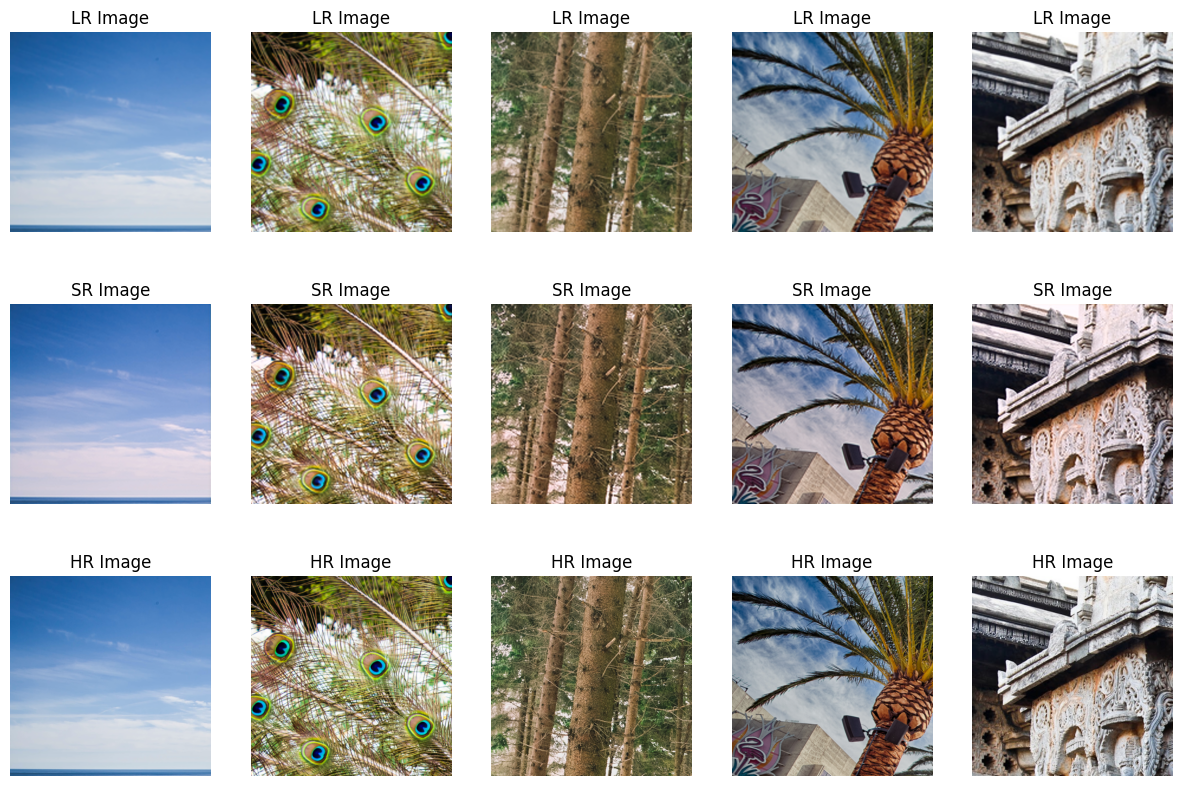

In [12]:
# Denormalize the pixel values
def denormalize(data):
    data = np.array(data)
    return (data * 255.).astype(np.uint8)

def predict(image, model):
    image = np.expand_dims(image, axis=0)
    sr = model.predict(image)
    sr = sr[0]
    sr = np.clip(sr * 255.0, 0, 255).astype(np.uint8)
    return sr

def predict_images(images, model):
    sr_images = []
    for img in images:
        sr_image = predict(img, model)
        sr_images.append(sr_image)
    return sr_images

# Plotting the images
sr_test_images = predict_images(X_test, srcnn_model)
y_test = denormalize(y_test)
X_test = denormalize(X_test)

fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i in range(5):
    axs[0, i].imshow(X_test[i])
    axs[0, i].set_title('LR Image')
    axs[0, i].axis('off')

    axs[1, i].imshow(sr_test_images[i])
    axs[1, i].set_title('SR Image')
    axs[1, i].axis('off')

    axs[2, i].imshow(y_test[i])
    axs[2, i].set_title('HR Image')
    axs[2, i].axis('off')

In [13]:
# Evaluate the model
def evaluate_model(input_images, testing_images):
    psnr_values = []
    ssim_values = []
    mse_values = []

    for i in range(len(input_images)):
        m, s, p = compare_images(input_images[i], testing_images[i])
        psnr_values.append(p)
        ssim_values.append(s)
        mse_values.append(m)

        # print(f"\nComparison {i+1}:")
        # print(f'  PSNR: {p:.4f}')
        # print(f'  SSIM: {s:.4f}')
        # print(f'  MSE: {m:.4f}')

    print("\nOverall Evaluation Metrics:")
    print(f'Average PSNR: {np.mean(psnr_values):.4f}')
    print(f'Average SSIM: {np.mean(ssim_values):.4f}')
    print(f'Average MSE: {np.mean(mse_values):.4f}')
    print(f'Range of PSNR: {np.min(psnr_values):.4f} - {np.max(psnr_values):.4f}')
    print(f'Range of SSIM: {np.min(ssim_values):.4f} - {np.max(ssim_values):.4f}')
    print(f'Range of MSE: {np.min(mse_values):.4f} - {np.max(mse_values):.4f}')


In [14]:
evaluate_model(y_test, sr_test_images)
evaluate_model(X_test, y_test)


Overall Evaluation Metrics:
Average PSNR: 30.1528
Average SSIM: 0.8926
Average MSE: 107.8839
Range of PSNR: 18.9426 - 49.5030
Range of SSIM: 0.5610 - 0.9918
Range of MSE: 0.7291 - 829.5155

Overall Evaluation Metrics:
Average PSNR: 34.2904
Average SSIM: 0.8825
Average MSE: 93.8065
Range of PSNR: 18.7908 - 58.9477
Range of SSIM: 0.4983 - 0.9982
Range of MSE: 0.0829 - 859.0077


In [15]:
output_dir = 'output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, img in enumerate(sr_test_images):
    img = Image.fromarray(img)
    img.save(os.path.join(output_dir, f'sr_image_{i}.png'))

print(f'All images saved to {output_dir}')

All images saved to output_images


In [16]:
# Save the model
srcnn_model.save('srcnn_model.keras')